C:\Users\fahds\AppData\Local\Temp\ipykernel_75424\996404117.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab10")


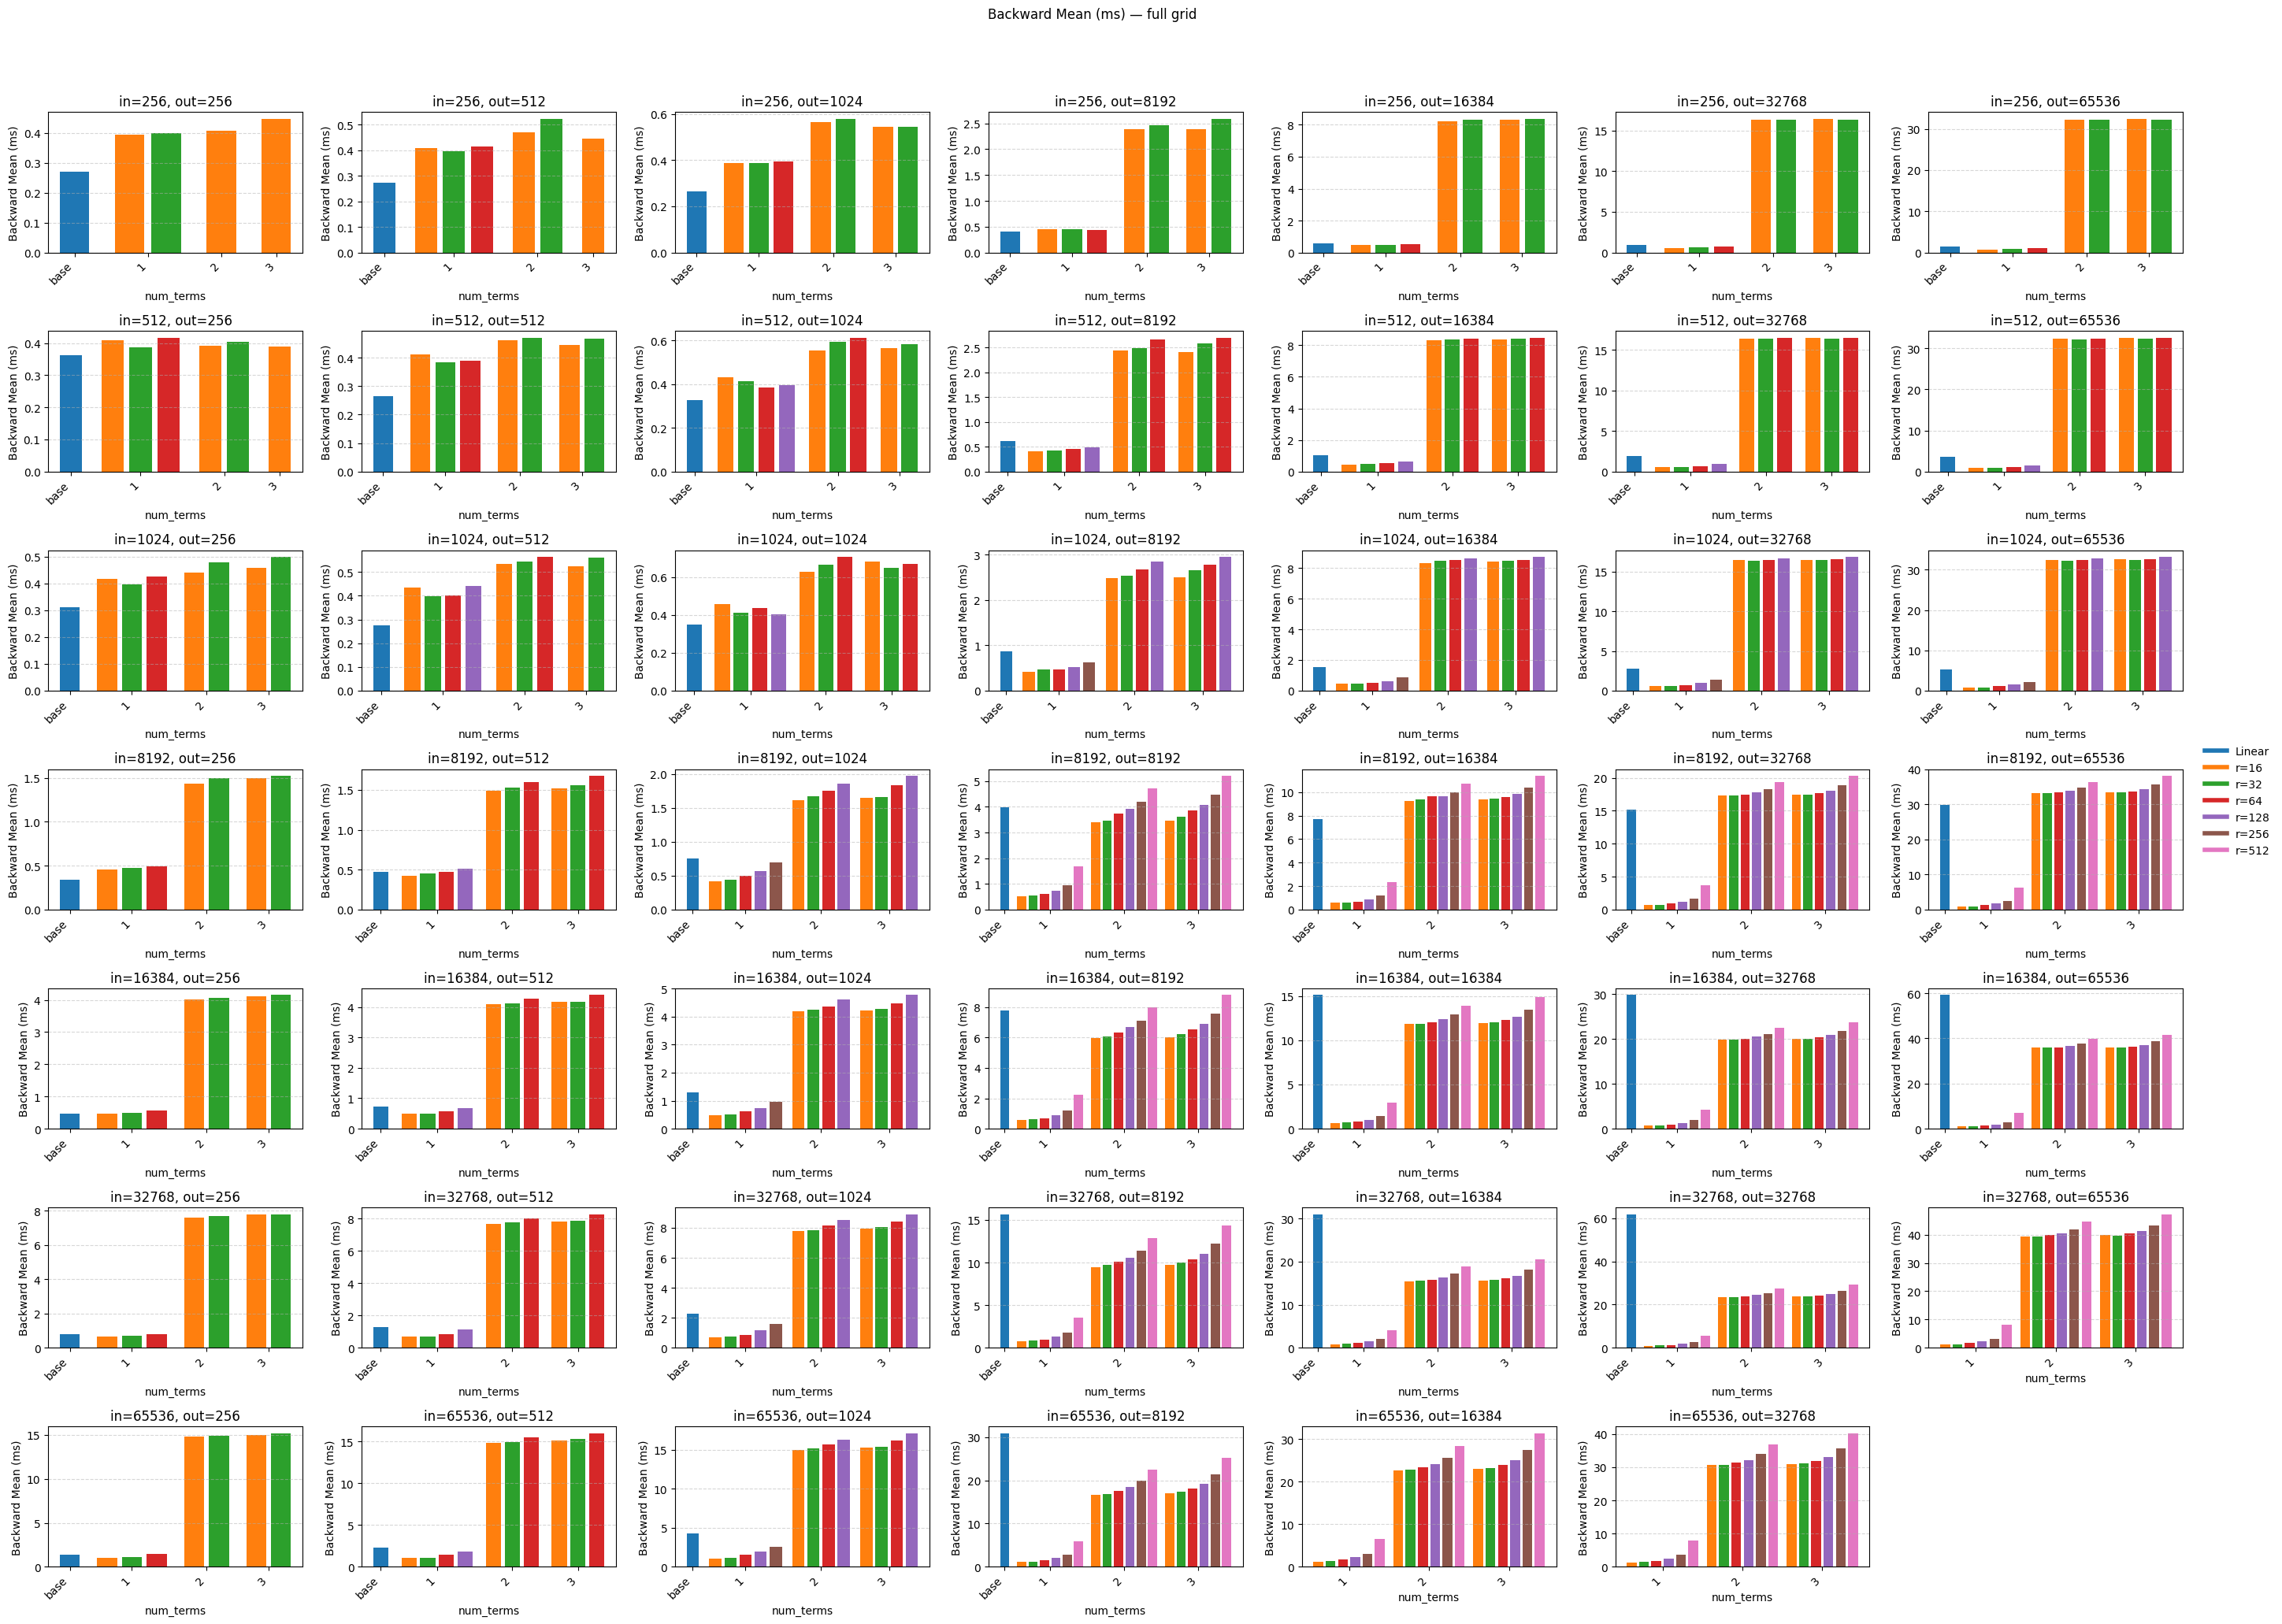

In [4]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.cm import get_cmap

# === Configuration: replace these with your actual CSV filenames and model names ===
csv1 = "torchLinear_no_tc_fc.csv"  # CSV with no variability in num_terms and low_rank
model1_name = "Linear"
csv2 = "sklinear_no_tc_fc_backonly_allcuda.csv"  # CSV with variability in num_terms and low_rank
model2_name = "sk"

# === Plot mode toggles ===
use_grid = True  # True: grid layout; False: standalone plots
all_in_one = True  # If True and use_grid, puts entire grid in one plot

# === Legend configuration (now fully adjustable) ===
legend_ncol = 1  # number of columns in the legend
legend_loc = "center left"  # legend anchor location
legend_bbox = (1.0, 0.5)  # (x, y) offset from plot bounding box
tight_rect = [0, 0, 1, 0.95]  # left, bottom, right, top margins for tight_layout


# === Read and clean data ===
def load_and_clean(csv):
    df = pd.read_csv(csv)
    return df[df["forward_mean_ms"].notna() & df["backward_mean_ms"].notna()]


df1 = load_and_clean(csv1)
df2 = load_and_clean(csv2)

# === Aggregate df1 ===
df1_agg = df1.groupby(["in_features", "out_features"], as_index=False).agg(
    {
        "forward_mean_ms": "mean",
        "forward_std_ms": "mean",
        "backward_mean_ms": "mean",
        "backward_std_ms": "mean",
    }
)

# === Unique axes ===
in_feats = sorted(set(df1_agg["in_features"]) | set(df2["in_features"]))
out_feats = sorted(set(df1_agg["out_features"]) | set(df2["out_features"]))

# === Tweak combos and unique low_rank ===
tweaks = (
    df2[["num_terms", "low_rank"]]
    .drop_duplicates()
    .sort_values(["num_terms", "low_rank"])
    .values
)
unique_lrs = sorted({lr for _, lr in tweaks})
cmap = get_cmap("tab10")
# Color per low_rank
grid_colors = {lr: cmap(i + 1) for i, lr in enumerate(unique_lrs)}
# Color for model1
base_color = cmap(0)


# === Stats helper ===
def get_stats(df, metric, in_f, out_f, nt=None, lr=None):
    sub = df[(df["in_features"] == in_f) & (df["out_features"] == out_f)]
    if nt is not None:
        sub = sub[(sub["num_terms"] == nt) & (sub["low_rank"] == lr)]
    if sub.empty:
        return None, None
    return sub[f"{metric}_mean_ms"].mean(), sub[f"{metric}_std_ms"].mean()


# === Plot block helper ===
def plot_block(fig, axes, metric, title, pairs):
    for ax, (in_f, out_f) in zip(axes.flat, pairs):
        labels, heights, errs, colors = [], [], [], []

        # base model
        m1, s1 = get_stats(df1_agg, metric, in_f, out_f)
        if m1 is not None:
            labels.append("base")
            heights.append(m1)
            errs.append(s1)
            colors.append(base_color)

        # other model tweaks
        for nt, lr in tweaks:
            m2, s2 = get_stats(df2, metric, in_f, out_f, nt, lr)
            if m2 is None:
                continue
            labels.append(str(nt))
            heights.append(m2)
            errs.append(s2)
            colors.append(grid_colors[lr])

        if not heights:
            ax.set_visible(False)
            continue

        # compute x positions with a small gap between label groups
        gap = 0.5
        x_positions, current = [], 0
        for idx, lab in enumerate(labels):
            x_positions.append(current)
            current += 1
            if idx + 1 == len(labels) or labels[idx + 1] != lab:
                current += gap
        x = np.array(x_positions)
        ax.bar(x, heights, color=colors, capsize=5)

        # grouped x-ticks by label
        positions = OrderedDict()
        for xi, lab in zip(x_positions, labels):
            positions.setdefault(lab, []).append(xi)
        group_positions = [sum(xs) / len(xs) for xs in positions.values()]
        ax.set_xticks(group_positions)
        ax.set_xticklabels(positions.keys(), rotation=45, ha="right")

        ax.set_title(f"in={in_f}, out={out_f}")
        ax.set_xlabel("num_terms")
        ax.set_ylabel(f"{title} Mean (ms)")
        ax.set_ylim(bottom=0)
        ax.grid(axis="y", linestyle="--", alpha=0.5)

    # Build legend entries (base + all low_rank variants)
    legend_entries = [plt.Line2D([0], [0], color=base_color, lw=4, label=model1_name)]
    legend_entries += [
        plt.Line2D([0], [0], color=grid_colors[lr], lw=4, label=f"r={lr}")
        for lr in unique_lrs
    ]

    # Place legend using configurable settings
    fig.legend(
        handles=legend_entries,
        loc=legend_loc,
        bbox_to_anchor=legend_bbox,
        ncol=legend_ncol,
        frameon=False,
    )


# === Main plotting loop ===
for metric, title in [("backward", "Backward")]:
    if use_grid:
        if all_in_one:
            n_r, n_c = len(out_feats), len(in_feats)
            fig, axes = plt.subplots(n_r, n_c, figsize=(4 * n_c, 3 * n_r))
            fig.suptitle(f"{title} Mean (ms) — full grid")
            plot_block(
                fig, axes, metric, title, [(i, o) for i in in_feats for o in out_feats]
            )
            plt.tight_layout(rect=tight_rect)
            plt.show()
        else:
            block = 1
            for i0 in range(0, len(out_feats), 2):
                for j0 in range(0, len(in_feats), 2):
                    rows = out_feats[i0 : i0 + 2]
                    cols = in_feats[j0 : j0 + 2]
                    pairs = [(i, o) for o in rows for i in cols]
                    fig, axes = plt.subplots(
                        len(rows), len(cols), figsize=(6 * len(cols), 4 * len(rows))
                    )
                    fig.suptitle(f"{title} Mean (ms) — tile {block}")
                    plot_block(fig, axes, metric, title, pairs)
                    plt.tight_layout(rect=tight_rect)
                    plt.show()
                    block += 1
    else:
        for out_f in out_feats:
            for in_f in in_feats:
                fig, ax = plt.subplots(figsize=(6, 4))
                plot_block(fig, np.array([ax]), metric, title, [(in_f, out_f)])
                plt.tight_layout()
                plt.show()